In [1]:
%load_ext autoreload
%autoreload 2

In [21]:

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from src.PPO.PPO import PPO, PPOContinuous
import pdb

env_name = "BipedalWalker-v2"
env = gym.make(env_name)

env.seed(10)

state_size = env.observation_space.shape[0]
action_size =env.action_space.shape[0]

print(state_size)
print(action_size)

# PPO Settings
update_every = 4000
num_learn = 80
win_condition = 0

# Agent settings
hidden_size=128
epsilon=0.2
entropy_beta=0.01
gamma=0.99
lr=0.0003

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
24
4


In [ ]:
agent = PPOContinuous(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)

In [ ]:

scores_deque = deque(maxlen=100)
scores = []
average_scores = []
max_score = -np.Inf

def train(n_episodes=10000, max_t=1500):
#   agent = PPO(state_size, action_size, hidden_size=hidden_size, epsilon=epsilon, entropy_beta=entropy_beta, gamma=gamma, lr=lr)
  steps = 0

  for episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    
    for t in range(max_t):
      steps += 1

      actions_tensor, log_prob = agent.act(torch.FloatTensor(state).to(device))
      actions = actions_tensor.cpu().data.numpy().flatten()
      next_state, reward, done, _ = env.step(actions_tensor.cpu().numpy())

      agent.mem.add(torch.FloatTensor(state), actions, reward, log_prob, done)

      # Update 
      state = next_state
      score += reward

      if steps >= update_every:
        agent.learn(num_learn)
        agent.mem.clear()
        steps = 0

      if done:
        break
    
    # Book Keeping
    scores_deque.append(score)
    scores.append(score)
    average_scores.append(np.mean(scores_deque))
      

    print("\rEpisode {}	Average Score: {:.2f}	Score: {:.2f}".format(episode, np.mean(scores_deque), score), end="")

    if episode % 100 == 0:
      print("\rEpisode {}	Average Score: {:.2f}".format(episode, np.mean(scores_deque)))   
      torch.save(agent.model.state_dict(), "walker_ppo_model_{}.pth".format(episode))
      torch.save(agent.model_old.state_dict(), "walker_ppo_model_old_{}.pth".format(episode))
    
    if np.mean(scores_deque) > win_condition:
      print("\rEnvironment Solved in {} episodes!".format(episode))
      break


  return scores, average_scores

scores, average_scores = train()

Episode 3	Average Score: -78.70	Score: -57.5348

/Users/darylrodrigo/Desktop/rl_lib/Policy Gradient/src/PPO/PPO.py:125: UserWarning: Using a target size (torch.Size([6000])) that is different to the input size (torch.Size([6000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surrogate_1, surrogate_2) + 0.5*F.mse_loss(values, discounted_returns) - self.entropy_beta*entropy


Episode 6	Average Score: -65.02	Score: -50.10

/Users/darylrodrigo/Desktop/rl_lib/Policy Gradient/src/PPO/PPO.py:125: UserWarning: Using a target size (torch.Size([4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = -torch.min(surrogate_1, surrogate_2) + 0.5*F.mse_loss(values, discounted_returns) - self.entropy_beta*entropy


Episode 23	Average Score: -57.20	Score: -50.15

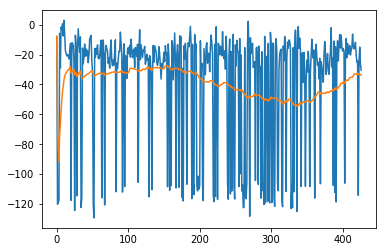

In [20]:
plt.plot(scores)
plt.plot(average_scores)

In [17]:
for episode in range(1):
    state = env.reset()
    score = 0
    input()

    for t in range(30000):
        actions_tensor, log_prob = agent.act(torch.FloatTensor(state))
        actions = actions_tensor.cpu().data.numpy().flatten()
        next_state, reward, done, _ = env.step(actions_tensor)

        
        score += reward
        
        env.render()
        
        if done:
            break;
        
        state = next_state

    print(score)
env.close()


tensor(-17.3377)
